Project: Ad Click Prediction    
Author: Chien-Hao Wang   
Date: 25/11/2025

## Data Ingestion & Exploratory Data Analysis (EDA) 

**Description:**    
This script establishes a connection to the Google BigQuery data warehouse, fetches the raw advertising data, and performs initial statistical analysis to understand the underlying distributions and correlations.

In [3]:
import os
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Set the path to your Google Cloud Service Account Key
# In a real production environment, use environment variables for security.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'service_account.json'

# Initialize BigQuery Client
client = bigquery.Client()

# Test Connection
query = "SELECT 'Connection Successful' as status"
try:
    df = client.query(query).to_dataframe()
    print("Connected Successful !")
    print(df)
except Exception as e:
    print("Fail Connected, See error messages below:")
    print(e)

c:\Users\jeffs\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Connected Successful !
                  status
0  Connection Successful


In [4]:
# --- Data Extraction (ETL) ---
query = """
    SELECT *
    FROM `ad-click-portfolio.marketing_data.ad_clicks_raw`
    LIMIT 10000; 
"""

print("Attempting to fetch data from BigQuery...")
try:
    df = client.query(query).to_dataframe()
    print(f"Data successfully loaded. Shape: {df.shape}")
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to fetch data from BigQuery...


c:\Users\jeffs\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data successfully loaded. Shape: (10000, 9)


In [11]:
# --- Data Integrity Check ---
# Basic info and missing values
info = df.info()
missing_values = df.isnull().sum()

# Calculate CTR
ctr = df['click'].mean()

# Checking if 'Missingness' correlates with Clicks
# This proves we shouldn't just drop rows.

features_with_missing = ['age', 'gender', 'device_type', 'browsing_history']

print("--- Impact of Missing Data on Click Rate ---")
for col in features_with_missing:
    # Create a temporary flag: Is the data missing?
    df[f'{col}_missing_flag'] = df[col].isnull()
    
    # Calculate CTR for Missing vs. Present data
    ctr_analysis = df.groupby(f'{col}_missing_flag')['click'].mean()
    print(f"\nFeature: {col}")
    print(ctr_analysis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             10000 non-null  Int64  
 1   full_name                      10000 non-null  object 
 2   age                            5234 non-null   float64
 3   gender                         5307 non-null   object 
 4   device_type                    8000 non-null   object 
 5   ad_position                    8000 non-null   object 
 6   browsing_history               5218 non-null   object 
 7   time_of_day                    8000 non-null   object 
 8   click                          10000 non-null  Int64  
 9   age_missing_flag               10000 non-null  bool   
 10  gender_missing_flag            10000 non-null  bool   
 11  device_type_missing_flag       10000 non-null  bool   
 12  browsing_history_missing_flag  10000 non-null  

c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\jeffs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{'CTR': 0.65, 'Missing Values': {'id': 0, 'full_name': 0, 'age': 4766, 'gender': 4693, 'device_type': 2000, 'ad_position': 2000, 'browsing_history': 4782, 'time_of_day': 2000, 'click': 0, 'age_missing_flag': 0, 'gender_missing_flag': 0, 'device_type_missing_flag': 0, 'browsing_history_missing_flag': 0}, 'Shape': (10000, 13), 'Columns': ['id', 'full_name', 'age', 'gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day', 'click', 'age_missing_flag', 'gender_missing_flag', 'device_type_missing_flag', 'browsing_history_missing_flag']}


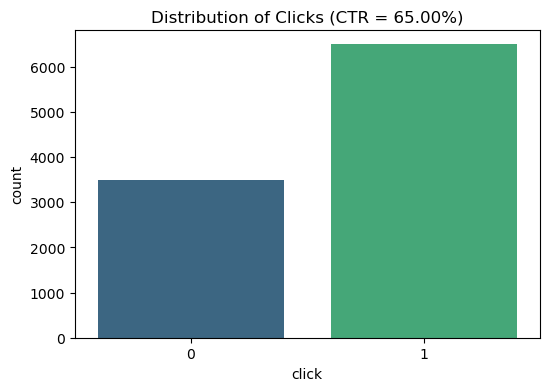

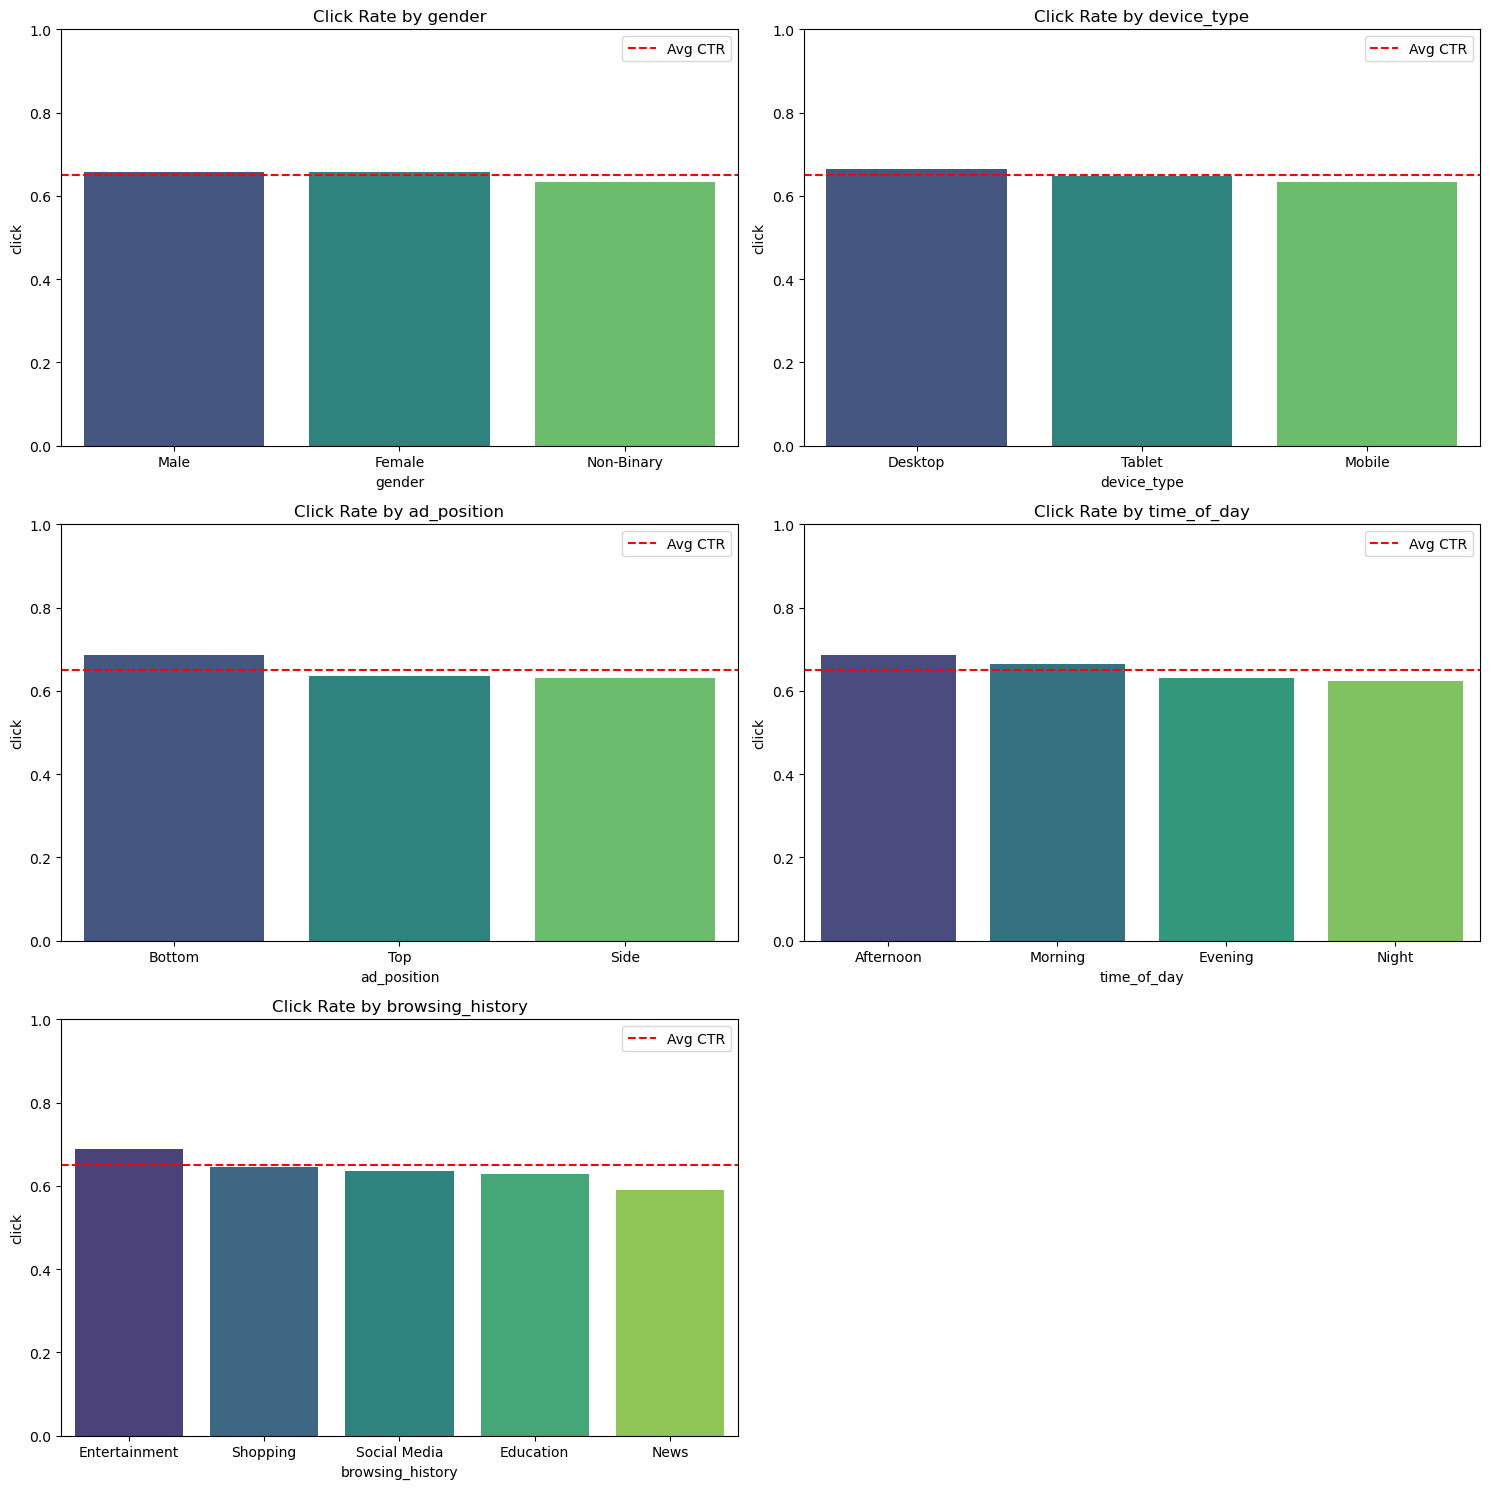

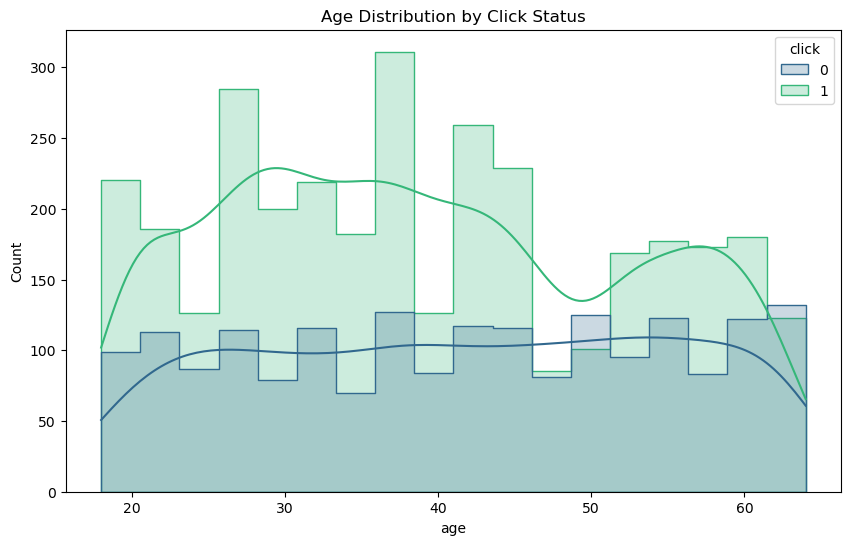

In [ ]:
# --- Exploratory Data Analysis (EDA) ---

# 1. Target Variable Distribution
# Rationale: Understanding class imbalance is crucial for model selection.
plt.figure(figsize=(6, 4))
sns.countplot(x='click', data=df, palette='viridis')
plt.title(f'Distribution of Clicks (CTR = {ctr:.2%})')
plt.savefig('ctr_distribution.png')

# 2. Click Rate by Categorical Features
categorical_cols = ['gender', 'device_type', 'ad_position', 'time_of_day', 'browsing_history']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Calculate click rate for each category
    click_rate = df.groupby(col)['click'].mean().reset_index().sort_values('click', ascending=False)
    sns.barplot(x=col, y='click', data=click_rate, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Click Rate by {col}')
    axes[i].set_ylim(0, 1)
    axes[i].axhline(ctr, color='red', linestyle='--', label='Avg CTR') # Add average CTR line
    axes[i].legend()

# Remove the last empty subplot if odd number of charts
if len(categorical_cols) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('categorical_click_rates.png')

# 3. Age Distribution by Click
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='click', kde=True, element="step", palette='viridis')
plt.title('Age Distribution by Click Status')
plt.savefig('age_distribution.png')

In [14]:
# --- STRATEGY IMPLEMENTATION ---

# Step 1: Handling Numerical Missingness (Age)
# Strategy: Median Imputation
# Rationale: Age distributions can be skewed; median is more robust than mean.
age_median = df['age'].median()
df['age_clean'] = df['age'].fillna(age_median)
print(f"\n[Action] Imputed missing 'age' with median value: {age_median}")

# Step 2: Handling Categorical Missingness
# Strategy: Constant Imputation ('Unknown')
# Rationale: As discovered in EDA, data is likely MAR/MNAR. The 'missingness' itself is a feature.
categorical_cols_with_missing = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

for col in categorical_cols_with_missing:
    # Fill NA with 'Unknown'
    df[col] = df[col].fillna('Unknown')

print(f"[Action] Filled missing values in {categorical_cols_with_missing} with 'Unknown'")

# Step 3: Verification
# Ensure no missing values remain in the columns we plan to use
remaining_nulls = df[['age_clean'] + categorical_cols_with_missing].isnull().sum().sum()
if remaining_nulls == 0:
    print("\n Data Quality Check Passed: No missing values remain in processed features.")
else:
    print(f"\n Warning: {remaining_nulls} missing values remain.")


[Action] Imputed missing 'age' with median value: 39.5
[Action] Filled missing values in ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day'] with 'Unknown'

 Data Quality Check Passed: No missing values remain in processed features.


In [15]:
# --- FEATURE ENCODING (Preparation for AI Model) ---

# We need to convert text to numbers. We will use One-Hot Encoding.
# Drop 'id' and 'full_name' as they have no predictive power.
# Drop original 'age' (use 'age_clean' instead).

features_to_encode = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

# Create the final dataset for modeling (X)
df_model = pd.get_dummies(
    df.drop(['id', 'full_name', 'age'], axis=1), 
    columns=features_to_encode, 
    drop_first=False  # We keep all columns to see "Unknown" explicitly
)

# Rename 'age_clean' to 'age' for clarity in the final dataset
df_model.rename(columns={'age_clean': 'age'}, inplace=True)

# Move 'click' (Target) to the last column for tidiness
target = df_model.pop('click')
df_model['click'] = target

print(f"\nFinal Modeling Dataset Shape: {df_model.shape}")
print("First 5 rows of processed data:")
display(df_model.head())


Final Modeling Dataset Shape: (10000, 29)
First 5 rows of processed data:


,age_missing_flag,gender_missing_flag,device_type_missing_flag,browsing_history_missing_flag,age,gender_Female,gender_Male,gender_Non-Binary,gender_Unknown,device_type_Desktop,...,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,browsing_history_Unknown,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,time_of_day_Unknown,click
0,True,True,False,False,39.5,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,0
1,True,False,False,True,39.5,True,False,False,False,True,...,False,False,False,True,False,True,False,False,False,0
2,True,False,False,True,39.5,True,False,False,False,False,...,False,False,False,True,False,True,False,False,False,1
3,True,False,False,True,39.5,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,1
4,True,False,False,True,39.5,True,False,False,False,False,...,False,False,False,True,False,True,False,False,False,1
